#                    Predicting The Age of Abalone 🐳🐠

![coffee](https://images.unsplash.com/photo-1495004984586-0dc339ad4b2c?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=3a6bedd3ca3b1ced9521b663a8f4ccfd&auto=format&fit=crop&w=667&q=80)

*courtesy of Sasha • Stories from Unsplash*

# Import packages & Data

In [7]:
#Thư viện cơ bản
import numpy as np 
import pandas as pd 

#Thư viện tạo biểu đồ để dễ so sánh
import matplotlib.pyplot as plt

#Thư viện kỹ thuật, chỉ số và mô hình hóa
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor

#In ra toàn bộ tệp trong input
import os
print(os.listdir("./input"))



['abalone.csv', 'abalone10.csv', 'abalone10.xlsx', 'testabalone.csv']


Đọc dữ liệu vào Pandas dataframe:



In [8]:
abalone = pd.read_csv('./input/abalone.csv')

In [9]:
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Lưu ý các đơn vị đo lường

- `Length` - mm
- `Diameter` - mm
- `Height` - mm
- `Whole weight` - grams
- `Shucked weight` - grams	
- `Viscera weight` -grams	
- `Shell weight` -grams

Đối với thuộc tính 'Rings', ta cộng thêm 1,5 (year) để ra số tuổi của bào ngư

In [10]:
abalone.shape

(4177, 9)

Chúng ta chỉ có một cột phân loại trong khi tám cột còn lại là số. Hãy tiếp tục và xem liệu có bất kỳ giá trị null nào không:

In [11]:
len(abalone.isnull())

4177

#  Data Cleaning




In [12]:
from scipy import stats
z= np.abs(stats.zscore(abalone.select_dtypes(include=[np.number])))
print(z)

        Length  Diameter    Height  Whole weight  Shucked weight  \
0     0.574558  0.432149  1.064424      0.641898        0.607685   
1     1.448986  1.439929  1.183978      1.230277        1.170910   
2     0.050033  0.122130  0.107991      0.309469        0.463500   
3     0.699476  0.432149  0.347099      0.637819        0.648238   
4     1.615544  1.540707  1.423087      1.272086        1.215968   
...        ...       ...       ...           ...             ...   
4172  0.341509  0.424464  0.609334      0.118813        0.047908   
4173  0.549706  0.323686  0.107991      0.279929        0.358808   
4174  0.632985  0.676409  1.565767      0.708212        0.748559   
4175  0.841182  0.777187  0.250672      0.541998        0.773341   
4176  1.549052  1.482634  1.326659      2.283681        2.640993   

      Viscera weight  Shell weight     Rings  
0           0.726212      0.638217  1.571544  
1           1.205221      1.212987  0.910013  
2           0.356690      0.207139  0.2896

In [13]:
abalone_o = abalone[(z < 3).all(axis=1)]

In [47]:
print("Shape of Abalones with outliers: "+ str(abalone.shape) , 
      "Shape of Abalones without outliers: " + str(abalone_o.shape))

Shape of Abalones with outliers: (4177, 9) Shape of Abalones without outliers: (4027, 9)


#  Feature Engineering 


In [15]:
low_cardinality_cols = [cname for cname in abalone_o.columns if
                        abalone_o[cname].nunique() < 10 and 
                       abalone_o[cname].dtype == "object"]
numeric_cols = [cname for cname in abalone_o.columns if
                                 abalone_o[cname].dtype in ['int64','float64']]

my_cols = low_cardinality_cols + numeric_cols
abalone_predictors = abalone_o[my_cols]

In [16]:
abalone_predictors.dtypes.sample(9)

Length            float64
Rings               int64
Diameter          float64
Shell weight      float64
Sex                object
Height            float64
Viscera weight    float64
Shucked weight    float64
Whole weight      float64
dtype: object

In [17]:
abalone_encoded_predictors = pd.get_dummies(abalone_predictors)

In [18]:
abalone_encoded_predictors.head(5)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [19]:
abalone_encoded_predictors.shape

(4027, 11)

#  Train Models


* Decision Trees, 
* Random Forest 



### Decision Trees



#### Cross Validation

In [46]:
cross_cols = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Sex_F','Sex_I','Sex_M']
X = abalone_encoded_predictors[cross_cols]
y = abalone_encoded_predictors.Rings

decision_pipeline = make_pipeline(DecisionTreeRegressor())
decision_scores = cross_val_score(decision_pipeline, X,y,scoring='neg_mean_squared_error')

print('MSE %2f' %(-1 * decision_scores.mean()))

MSE 7.573334


#### Train Test Split

In [36]:
dt_train_X,dt_test_X,dt_train_y,dt_test_y = train_test_split(X,y)

In [37]:
#Tạo hàm get_mse() để trả về lỗi bình phương trung bình
def get_mse(max_leaf_nodes,dt_train_X,dt_test_X,dt_train_y,dt_test_y ):
    model_pipeline = make_pipeline(DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes,random_state=0))
    model_pipeline.fit(dt_train_X,dt_train_y)
    preds_val = model_pipeline.predict(dt_test_X)
    mse = mean_squared_error(dt_test_y,preds_val)
    return(mse)

In [38]:
for max_leaf_nodes in [5,50,500,5000]:
    my_mse = get_mse(max_leaf_nodes,dt_train_X,dt_test_X,dt_train_y,dt_test_y)
    print("Max leaf nodes: %d \t\t MSE: %d" %(max_leaf_nodes,my_mse))

Max leaf nodes: 5 		 MSE: 4
Max leaf nodes: 50 		 MSE: 4
Max leaf nodes: 500 		 MSE: 6
Max leaf nodes: 5000 		 MSE: 7


In [39]:
decision_split_pipeline = make_pipeline(DecisionTreeRegressor(max_leaf_nodes=5))
decision_split_pipeline.fit(dt_train_X,dt_train_y)
decision_tree_prediction = decision_split_pipeline.predict(dt_test_X)
print("MSE: " + str(mean_squared_error(decision_tree_prediction,dt_test_y)))

MSE: 4.7815234556627


In [40]:
acc_decision = decision_split_pipeline.score(dt_test_X,dt_test_y)
print("Acc:", acc_decision )

Acc: 0.38791834651055124


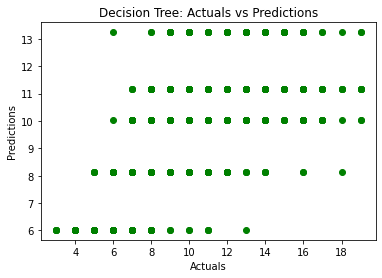

In [26]:
plt.scatter(dt_test_y,decision_tree_prediction,color='green')
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Decision Tree: Actuals vs Predictions')
plt.show()

### Random Forests



#### Cross Validation

In [31]:
forest_pipeline = make_pipeline(RandomForestRegressor(random_state=1))
forest_scores = cross_val_score(forest_pipeline, X,y,scoring="neg_mean_squared_error")
print('MSE %2f' %(-1 * forest_scores.mean()))

MSE 4.004081


#### Train Test Split

In [32]:
f_train_X,f_test_X,f_train_y,f_test_y = train_test_split(X,y)
forest_split_pipeline = make_pipeline(RandomForestRegressor(random_state=1))
forest_split_pipeline.fit(f_train_X,f_train_y)
forest_predictions = forest_split_pipeline.predict(f_test_X)
print("Accuracy:",forest_split_pipeline.score(f_test_X,f_test_y))
print("MSE:",str(mean_squared_error(forest_predictions,f_test_y)))


Accuracy: 0.542265054613349
MSE: 3.4059467725918573


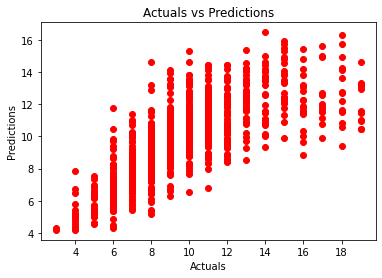

In [29]:
plt.scatter(f_test_y,forest_predictions,color='red')
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Actuals vs Predictions')
plt.show()